# SED

### Imports

In [1]:
from bigraph_viz import plot_bigraph, plot_flow, pf
from bigraph_viz.dict_utils import schema_keys
from sed2.core import register, ports, annotate, Composite, ProcessRegistry

schema_keys.extend(['_id', 'config'])

### Make Processes/Composites examples and register

In [2]:
sed_process_registry = ProcessRegistry()

@register(
    identifier='control:range_iterator',
    registry=sed_process_registry)
@ports({
    'inputs': {
        'trials': 'int'},
    'outputs': {
        'results': 'list'}})
@annotate('more info here?')
class RangeIterator(Composite):
    def update(self, state):
        trials = state.get('trials', 0)
        for i in range(trials):
            for process_path, process in self.processes.items():
                self.update_process(process_path, state)
        return {
            'results': self.states['value'],
            'trials': 0
        }


@register(
    identifier='math:sum_list',
    registry=sed_process_registry)
@ports({
    'inputs': {'values': 'list[float]'},
    'outputs': {'result': 'float'}})
@annotate('more info here?')
def add_list(values):
    if not isinstance(values, list):
        values = [values]
    return sum(values)


@register(
    identifier='math:add_two',
    registry=sed_process_registry)
@ports({
    'inputs': {'a': 'float', 'b': 'float'},
    'outputs': {'result': 'float'}})
@annotate('more info here?')
def add_two(a, b):
    return a + b
    
    
print(pf(sed_process_registry.registry))

{ 'control:range_iterator': { 'address': <class '__main__.RangeIterator'>,
                              'annotation': 'more info here?',
                              'class': 'composite',
                              'ports': {'results': 'list', 'trials': 'int'}},
  'math:add_two': { 'address': <function add_two at 0x1064cc940>,
                    'annotation': 'more info here?',
                    'class': 'function',
                    'ports': {'a': 'float', 'b': 'float', 'result': 'float'}},
  'math:sum_list': { 'address': <function add_list at 0x1064cc8b0>,
                     'annotation': 'more info here?',
                     'class': 'function',
                     'ports': {'result': 'float', 'values': 'list[float]'}}}


### Instance

In [3]:
config1 = {
    # top-level state
    'trials': 10,
    'results': None,  # this should be filled in automatically

    # a composite process
    'for_loop': {
        '_id': 'control:range_iterator',
        'wires': {
            'trials': 'trials',
            'results': 'results',
        },

        # state within for_loop
        'value': 0,
        'added': 1,

        # process within for_loop
        'add': {
            '_id': 'math:add_two',
            'wires': {
                'a': 'value',
                'b': 'added',
                'result': 'value',
            },
        }
    },
    'wires': {
        'results': 'results',
        'trials': 'trials',
    }
}

In [4]:
sim_experiment = Composite(
    config=config1,
    process_registry=sed_process_registry)

state = {}
results = sim_experiment.update(state=state)

# print(pf(sim_experiment.config))
print(results)



{'results': 10, 'trials': 0}


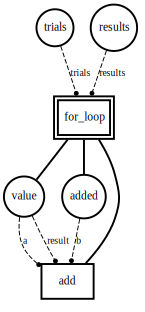

In [5]:
plot_bigraph(config1)